In [1]:
import qctoolkit as qtk
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import re
from datetime import datetime
import qmnet_model as qnm
import qmnet_tools as qnt
import qmnet_train as qntrain
import tensorflow as tf
from IPython.core.debugger import Tracer

%matplotlib inline

clear_output()

In [2]:
from horton import GOBasisFamily
#basis = GOBasisFamily('basis', filename='basis/sto2g/H_Ne_uncontracted.nwchem')
#basis = '3-21g'
#basis = 'sto-3g'
#basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Ne.nwchem')
basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Be-s.nwchem')

resolution = 0.005
batch_size = 30000

In [3]:
molstr_list = [
    'HH',
    'HHe+',
    'HLi',
    'HBe+',
    'HeHe',
    'HeLi+',
    'HeBe',
    'LiLi',
    'LiBe+',
    'BeBe',
]

In [4]:
inp_grp = []
#inp_dump = []
for molstr in molstr_list:
    if '+' in molstr:
        charge = 1
    elif '-' in molstr:
        charge = -1
    else:
        charge = 0
    alist = re.findall('[A-Z][a-z]*', molstr)
    Zs = [qtk.n2Z(a) for a in alist]
    inp_list = []
    inp_grp.append(inp_list)
    #inp_dump.append(inp_list)
    res = resolution
    for R in np.arange(0.3, 4.0 + res, res):
        mol = qtk.Molecule()
        ZR = [[Zs[0], 0,0,0], [Zs[1], R, 0, 0]]
        mol.build(ZR)
        mol.charge = charge
        mol.name = mol.name + '_%s' % str(R)
        inp = qtk.QMInp(mol, program='horton', basis_set=basis, scf_step=30)
        try:
            inp.run()
            D, U = np.linalg.eigh(inp.olp)
            inp.X = U / np.sqrt(D)
            
            # to save inps into pickle file
            #inp.delete_ht_types()
            #inp.delete_matrices()
            
            inp_list.append(inp)
        except:
            pass
    print "%s finished" % mol.name
print [len(inp) for inp in inp_grp]

H2_4.0 finished
H1He1_4.0 finished
H1Li1_4.0 finished
H1Be1_4.0 finished
He2_4.0 finished
He1Li1_4.0 finished
He1Be1_4.0 finished
Li2_4.0 finished
Li1Be1_4.0 finished
Be2_4.0 finished
[741, 741, 741, 563, 741, 741, 741, 741, 741, 741]


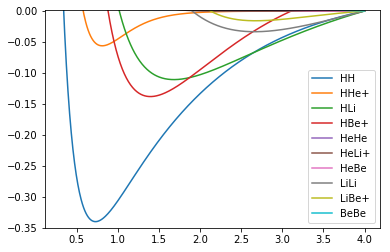

In [5]:
for i in range(len(inp_grp)):
    inp = inp_grp[i]
    E = np.array([o.Et for o in inp])
    E = E-E[-1]
    R = [o.molecule.R[1,0] for o in inp]
    #print E
    plt.plot(R, E, label=molstr_list[i])
plt.ylim(-0.35, 0.001)
plt.legend()

In [6]:
inp_grp[0][0].olp.shape

(4, 4)

In [6]:
inp = inp_grp[0][5]
I_np, Er_np, occ, nn = qnt.get_input_tensor(inp)
C = inp.ht_exp_alpha.coeffs.__array__()
print qnt.get_output(I_np, Er_np, occ, nn, C)
print inp.Et

-0.730430578246
-0.730430578246


In [5]:
lr = 0.001
const_lr = {
    'learn_rate_start':0.1, 
    'learn_rate_min':lr, 
    'learn_rate_base':1.0, 
}
vary_lr_H2 = {
    'learn_rate_start':0.001, 
    'learn_rate_min':0.000001, 
    'learn_rate_steps':100, 
    'learn_rate_base':0.8
}

vary_lr_LiH = {
    'learn_rate_start':0.001, 
    'learn_rate_min':0.00005, 
    'learn_rate_steps':300, 
    'learn_rate_base':0.8
}

vary_lr = {
    'learn_rate_start':0.001, 
    'learn_rate_min':0.00005, 
    'learn_rate_steps':500, 
    'learn_rate_base':0.8
}

reload(qnt)
reload(qnm)
reload(qnm.qnl)
reload(qntrain)
reload(qntrain.qnt)
train = qntrain.train
#qm_model = qnm.I0_S2x5_O1x3
#qm_model = qnm.Ix0_dS5x5_O3x5
qm_model = qnm.I0_S1x2_d_S1x2_O1x3_SCF
#qm_model = qnm.I3_S3O3x5d_S3O3x5_O3x3
#qm_model = qnm.I3_S5x10_d_S5x5_dS2_O3x5
#qm_model = qnm.Ix3_R5_O2
#qm_model = qnm.Ix3_R5h2b_O2
#qm_model = qnm.Ix3_R3h2b_R5h1b_O2
#qm_model = qnm.I2_R5h2b_d_R3h1b_d_R2h1b_O5
#qm_model = qnm.Fock_error_test
#qm_model = qnm.Ix0_dS5x5_O3x5
#qm_model = qnm.I2_R5h2b_R3h1b_O2

In [9]:
tf.reset_default_graph()

# train(qm_model, inp_grp, 'H2_simple_test3', valid_ind=0, train_list=[0], threshold=1E-4,
#       from_scratch=True, batch_size=16, print_step=50, kp=1.0, save_step=200,
#       save_full_valid_Cprd=True,
#       **vary_lr_H2)
mol_ind = 1
train(qm_model, inp_grp, '%s_simple_SCF_test' % molstr_list[mol_ind].replace('+',''), 
      valid_ind=mol_ind, train_list=[mol_ind], threshold=5E-5,
      from_scratch=True, batch_size=16, print_step=50, kp=1.0, save_step=200,
      save_full_valid_Cprd=True, molstr_list = molstr_list,
      loss='emin',
      **vary_lr_LiH)
#train('increment_test', valid_ind=2, train_list=[0, 1, 3], 
#      from_scratch=False, batch_size=256, print_step=200, **vary_lr)
# train(qm_model, inp_grp, 'A2_rnn_test', valid_ind=2, from_scratch=False, batch_size=256, 
#       print_step=200, threshold=1E-4, **vary_lr)

root name: HHe_simple_SCF_test
model: <function I0_S1x2_d_S1x2_O1x3_SCF at 0x7f9068e789b0>
train/test/validation size: 666/75/741 
optimizer: <class 'tensorflow.python.training.adam.AdamOptimizer'>
reg_scale: 0.0
keep_prob: 1.0
batch size: 16
number of batches: 42
training set: ['HHe+']
validation: HHe+
learning rate min: 5e-05
learning rate steps: 300
learning rate start: 0.001
learning rate base: 0.8
print step: 50
history step: 1
threshold: 5e-05
maxiter: 100000
execuate time: 2017/10/14 15:02:13


start from scratch...

epoch:    50 train/test/validatoin error: 0.303754/0.232450/0.282469 at rate 0.000964
epoch:   100 train/test/validatoin error: 0.175308/0.117476/0.149095 at rate 0.000929
epoch:   150 train/test/validatoin error: 0.047950/0.042857/0.049858 at rate 0.000895
epoch:   200 train/test/validatoin error: 0.028432/0.023782/0.029251 at rate 0.000862
Model and history backup

epoch:   250 train/test/validatoin error: 0.023570/0.037147/0.024444 at rate 0.000831
epoch:   300 t

In [14]:
range(1, 3)

[1, 2]

In [ ]:
reload(qnt)
reload(qnm)
reload(qnm.qnl)
reload(qntrain)
reload(qntrain.qnt)
train = qntrain.train
qm_model = qnm.I0_S1x2_d_S1x2_O1x3_SCF

for train_length in range(2, len(inp_grp)+1):
    train(qm_model, inp_grp, 'A2_increment_SCF_%02d' % train_length, 
          valid_ind=0, train_list=range(1, train_length), threshold=1E-4,
          from_scratch=True, batch_size=16, print_step=1000, kp=1.0, save_step=2000,
          save_full_valid_Cprd=False, loss='emin', 
          molstr_list = molstr_list,
          **vary_lr_LiH)

root name: A2_increment_SCF_02
model: <function I0_S1x2_d_S1x2_O1x3_SCF at 0x7ff3870e1938>
train/test/validation size: 666/75/741 
optimizer: <class 'tensorflow.python.training.adam.AdamOptimizer'>
loss: energy
reg_scale: 0.0
keep_prob: 1.0
batch size: 16
number of batches: 42
training set: ['HHe+']
validation: HH
learning rate min: 5e-05
learning rate steps: 300
learning rate start: 0.001
learning rate base: 0.8
print step: 1000
history step: 1
threshold: 0.0001
maxiter: 100000
execuate time: 2017/10/16 19:07:23


start from scratch...

